# Instâncias reais

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).


* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.

In [1]:
import sys
import os
import pandas as pd
import numpy as np

import joblib
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics  import average_precision_score, make_scorer, roc_curve,f1_score, precision_score, recall_score, fbeta_score, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report,precision_recall_curve
import seaborn as sns

import matplotlib.pyplot as plt

import shap

from sklearn.model_selection import TimeSeriesSplit

from pyod.models.ecod import ECOD

from pyod.models.suod import SUOD

from pyod.models.xgbod import XGBOD

from pyod.models.loda import LODA

from pyod.models.pca import PCA

from sklearn.neighbors import LocalOutlierFactor

from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

from sklearn.neighbors import LocalOutlierFactor

from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.pipeline import make_pipeline
from sklearn.svm import OneClassSVM

import plotly.graph_objects as go

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


c:\Users\User\anaconda3\envs\PhD\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import plotly.graph_objects as go

In [3]:
def metrics(y_test, y_pred, scores):
    cm = list()
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm)                      
    plt.figure(figsize=(8,6))  
    sns.heatmap(cm_df, annot=True)
    print("Classification Report: \n", classification_report(y_test, y_pred, digits=5))  


    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    print("Specificity:", TN/(TN+FP))


    roc_auc = roc_auc_score(y_test, scores)#, max_fpr=0.1)
    gini = 2*roc_auc -1
    print("Gini: ",gini)
    print("ROC AUC:: ",roc_auc)

In [4]:
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

def find_optimal_threshold(y_true, y_scores, max_fpr=None):
    """
    Encontra o threshold ótimo com base na curva ROC,
    considerando apenas FPR <= max_fpr se especificado.
    Retorna fpr, tpr, thresholds, best_threshold e roc_auc.
    """
    # Calcula curva ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    # Filtra os pontos se max_fpr for especificado
    if max_fpr is not None:
        mask = fpr <= max_fpr
        fpr = fpr[mask]
        tpr = tpr[mask]
        thresholds = thresholds[mask]

    # AUC usando função apropriada
    roc_auc = roc_auc_score(y_true, y_scores, max_fpr=max_fpr)

    # Índice do ponto ótimo
    optimal_idx = np.argmax(tpr - fpr)
    best_threshold = thresholds[optimal_idx]

    return fpr, tpr, thresholds, best_threshold, roc_auc



def plot_roc_curve(fpr, tpr, thresholds, best_threshold, roc_auc, max_fpr=None):
    """
    Plota a curva ROC a partir de fpr, tpr e thresholds já calculados.
    Destaca o melhor threshold.
    """
    optimal_idx = np.where(thresholds == best_threshold)[0][0]

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.3f})', lw=2)
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', zorder=5,
                label=f'Melhor Threshold = {best_threshold:.3f}')

    # Linhas auxiliares para melhor visualização
    plt.axhline(y=tpr[optimal_idx], color='gray', linestyle='--', alpha=0.6)
    plt.axvline(x=fpr[optimal_idx], color='gray', linestyle='--', alpha=0.6)

    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
    plt.title(f'Curva ROC{" (FPR ≤ " + str(max_fpr) + ")" if max_fpr else ""}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [5]:
class ToDataFrameTransformer(BaseEstimator, TransformerMixin):
    """
    Transformador para converter arrays NumPy em DataFrames, mantendo os nomes das colunas.
    """
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        # Não há nada para ajustar, apenas retorna o próprio objeto
        return self

    def transform(self, X):
        # Converte o array NumPy em DataFrame com os nomes das colunas fornecidos
        if self.columns is not None:
            return pd.DataFrame(X, columns=self.columns)
        return pd.DataFrame(X)

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [6]:
def plot_learning_curve_cross_validation(df, title, ylim=None, train_sizes=np.linspace(1, 1000, 1000)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    # plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Interações")
    plt.ylabel("AUC-ROC")

    test_scores_mean = df.iloc[:, 0]
    test_scores_std = df.iloc[:, 1]
    plt.grid()

    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, test_scores_mean, color="g",
             label="Validação cruzada")

    plt.legend(loc="best")
    return plt

In [7]:
train = pd.read_parquet('./data/skab_train_agg_dwt.parquet.gzip') 
test = pd.read_parquet('./data/skab_test_agg_dwt.parquet.gzip') 

In [8]:
train = train.rename(columns={'anomaly': 'target', 'datetime': 'timestamp'})
test = test.rename(columns={'anomaly': 'target', 'datetime': 'timestamp'})

In [9]:
train.head()

,Volume Flow RateRMS_mean,Volume Flow RateRMS_std,Volume Flow RateRMS_min,Volume Flow RateRMS_max,Volume Flow RateRMS_energy_L0,Volume Flow RateRMS_std_L0,timestamp,valve,target
0,32.115408,0.324407,32.000,32.9962,0.999943,0.279597,2020-03-09 10:14:00,value1,0.0
1,32.293166,0.493304,31.004,32.9962,0.999856,0.455720,2020-03-09 10:15:00,value1,0.0
2,32.105353,0.308289,32.000,32.9964,0.999943,0.255478,2020-03-09 10:16:00,value1,0.0
3,32.070182,0.256715,32.000,32.9964,0.999963,0.233720,2020-03-09 10:17:00,value1,0.0
4,32.157911,0.366335,32.000,32.9966,0.999929,0.339662,2020-03-09 10:18:00,value1,0.0


In [10]:
test.head()

,Volume Flow RateRMS_mean,Volume Flow RateRMS_std,Volume Flow RateRMS_min,Volume Flow RateRMS_max,Volume Flow RateRMS_energy_L0,Volume Flow RateRMS_std_L0,timestamp,valve,target
256,29.859143,1.468449,28.0263,32.9745,0.999925,1.977376,2020-03-09 14:31:00,value1,1.0
257,32.051431,0.423857,31.0265,32.9743,0.999911,0.431980,2020-03-09 14:32:00,value1,0.0
258,32.232359,0.490260,31.0265,33.0000,0.999890,0.469790,2020-03-09 14:33:00,value1,0.0
259,32.140928,0.339742,32.0000,32.9740,0.999939,0.317402,2020-03-09 14:34:00,value1,0.0
260,32.263825,0.429386,32.0000,33.0000,0.999905,0.395182,2020-03-09 14:35:00,value1,0.0


In [11]:
train.target.value_counts()

target
0.0    193
1.0    126
Name: count, dtype: int64

In [12]:
feature_model= [col for col in train.columns if col not in ['changepoint', 'timestamp', 'valve', 'target']]
feature_model

['Volume Flow RateRMS_mean',
 'Volume Flow RateRMS_std',
 'Volume Flow RateRMS_min',
 'Volume Flow RateRMS_max',
 'Volume Flow RateRMS_energy_L0',
 'Volume Flow RateRMS_std_L0']

In [13]:
development = train.reset_index(drop=True)

# development = development[(development['well']=='WELL-00006')].reset_index(drop=True)

development.shape

(319, 9)

In [14]:
validation = test.reset_index(drop=True)
validation.shape

(80, 9)

In [15]:
validation.head()

,Volume Flow RateRMS_mean,Volume Flow RateRMS_std,Volume Flow RateRMS_min,Volume Flow RateRMS_max,Volume Flow RateRMS_energy_L0,Volume Flow RateRMS_std_L0,timestamp,valve,target
0,29.859143,1.468449,28.0263,32.9745,0.999925,1.977376,2020-03-09 14:31:00,value1,1.0
1,32.051431,0.423857,31.0265,32.9743,0.999911,0.431980,2020-03-09 14:32:00,value1,0.0
2,32.232359,0.490260,31.0265,33.0000,0.999890,0.469790,2020-03-09 14:33:00,value1,0.0
3,32.140928,0.339742,32.0000,32.9740,0.999939,0.317402,2020-03-09 14:34:00,value1,0.0
4,32.263825,0.429386,32.0000,33.0000,0.999905,0.395182,2020-03-09 14:35:00,value1,0.0


In [16]:
# validation_well = validation[(validation['well']=='WELL-00006')].reset_index(drop=True)

# validation_well.shape

In [17]:
train_no_anomalies = development[development.target==0]
train_no_anomalies.shape

(193, 9)

In [18]:
development

,Volume Flow RateRMS_mean,Volume Flow RateRMS_std,Volume Flow RateRMS_min,Volume Flow RateRMS_max,Volume Flow RateRMS_energy_L0,Volume Flow RateRMS_std_L0,timestamp,valve,target
0,32.115408,0.324407,32.0000,32.9962,0.999943,0.279597,2020-03-09 10:14:00,value1,0.0
1,32.293166,0.493304,31.0040,32.9962,0.999856,0.455720,2020-03-09 10:15:00,value1,0.0
2,32.105353,0.308289,32.0000,32.9964,0.999943,0.255478,2020-03-09 10:16:00,value1,0.0
3,32.070182,0.256715,32.0000,32.9964,0.999963,0.233720,2020-03-09 10:17:00,value1,0.0
4,32.157911,0.366335,32.0000,32.9966,0.999929,0.339662,2020-03-09 10:18:00,value1,0.0
...,...,...,...,...,...,...,...,...,...
314,32.036802,0.399892,31.0429,32.9584,0.999893,0.297338,2020-03-09 16:54:00,value2,0.0
315,31.876698,0.366949,31.0429,32.9584,0.999939,0.444783,2020-03-09 16:55:00,value2,0.0
316,31.982255,0.288388,31.0431,32.9581,0.999962,0.263289,2020-03-09 16:56:00,value2,0.0
317,31.947795,0.448944,31.0434,32.9581,0.999869,0.334147,2020-03-09 16:57:00,value2,0.0


In [19]:
X_dev = development[feature_model].values
y_dev = development['target'].values

In [20]:
y_dev.sum()

126.0

In [21]:
len(y_dev)

319

In [22]:
X_no_anomalies = train_no_anomalies[feature_model].values

### Optimization with TPE (Tree-Structured Parzen Estimator)

### Isolation Forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

In [23]:
import optuna
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
import numpy as np

In [24]:
def build_iforest(params):
    estimator = IsolationForest(
        n_estimators=int(params['n_estimators']),
        contamination=params['contamination'],
        max_samples=params['max_samples'],
        max_features=params['max_features'],
        random_state=42,
        n_jobs=-1
    )
    return Pipeline([
        ('scaler', StandardScaler()),
        ('estimator', estimator)
    ])

def transform_iforest_params(params):
    return {
        'n_estimators': int(params[0]),
        'contamination': float(params[1]),
        'max_samples': float(params[2]),
        'max_features': float(params[3])
    }

def evaluate_model(model, dataset, tscv, features):
    fit_scores = []
    for train_index, test_index in tscv.split(dataset):
        train_data = dataset.iloc[train_index]
        X_train = train_data[train_data['target'] == 0][features]
        X_test = dataset.iloc[test_index][features]
        y_test = dataset.iloc[test_index]['target']

        model.fit(X_train)
        y_scores = -model.decision_function(X_test)
        # y_pred = model.predict(X_test)
        # y_pred = np.where(y_pred == 1, 0, 1)  # Convertendo -1 para 1 (anomaly) e 1 para 0 (normal)

        score = roc_auc_score(y_test, y_scores)
        # score = f1_score(y_test, y_pred, average='binary', zero_division=0)
        fit_scores.append(score)

    mean_score = np.mean(fit_scores)
    std_score = np.std(fit_scores)

    return mean_score, std_score

def objective_iforest(trial, dataset, tscv, features):
    n_estimators = trial.suggest_int('n_estimators', 5, 256)
    contamination = trial.suggest_float('contamination', 0.0001, 0.005)
    max_samples = trial.suggest_float('max_samples', 0.3, 1.0)
    max_features = trial.suggest_float('max_features', 0.3, 1.0)
    params = [n_estimators, contamination, max_samples, max_features]

    model_params = transform_iforest_params(params)
    model = build_iforest(model_params)
    mean_score, std_score = evaluate_model(model, dataset, tscv, features)

    trial.set_user_attr("score_mean", mean_score)
    trial.set_user_attr("score_std", std_score)

    return 100*(mean_score - std_score) 

def optuna_optimization_iforest(dataset, tscv, features, n_trials=50):
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')
    study.optimize(lambda trial: objective_iforest(trial, dataset, tscv, features), n_trials=n_trials)

    return study.best_params, study

In [25]:
import time

tscv = TimeSeriesSplit(n_splits=3)
start_time = time.time()  # Inicia o cronômetro

best_params_iforest, study_iforest = optuna_optimization_iforest(development, tscv, feature_model, n_trials=1000)
print(f"Melhores parâmetros para Isolation Forest: {best_params_iforest}")

total_time = time.time() - start_time  # Calcula o tempo total

print("\n--- Resultados Finais ---")
# Melhores parâmetros encontrados
# print("Melhores parâmetros para IsolationForest:", best_params_pca)
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")

[I 2025-10-10 22:20:40,926] A new study created in memory with name: no-name-2e155f2d-1408-441e-947b-5cac085d6a91
[I 2025-10-10 22:20:42,547] Trial 0 finished with value: 87.04325333501352 and parameters: {'n_estimators': 239, 'contamination': 0.0023038210681711776, 'max_samples': 0.47993203929485967, 'max_features': 0.6236069514082905}. Best is trial 0 with value: 87.04325333501352.
[I 2025-10-10 22:20:44,123] Trial 1 finished with value: 86.56839303470902 and parameters: {'n_estimators': 243, 'contamination': 0.0009530054668912124, 'max_samples': 0.5114735963616293, 'max_features': 0.6513036597966038}. Best is trial 0 with value: 87.04325333501352.
[I 2025-10-10 22:20:44,494] Trial 2 finished with value: 88.2815211282512 and parameters: {'n_estimators': 52, 'contamination': 0.0012891788279805428, 'max_samples': 0.9337346353283622, 'max_features': 0.8301519442385943}. Best is trial 2 with value: 88.2815211282512.
[I 2025-10-10 22:20:45,166] Trial 3 finished with value: 88.760414460642

Melhores parâmetros para Isolation Forest: {'n_estimators': 53, 'contamination': 0.00209933084692027, 'max_samples': 0.9438849154722311, 'max_features': 0.9628904653784761}

--- Resultados Finais ---
Tempo total de execução: 737.59 segundos
Tempo total de execução: 12.29 minutos


In [26]:
data_metrics_iforest = []

for trial in study_iforest.trials:
    data_metrics_iforest.append({
        'trial': trial.number,
        'roc_auc_mean': trial.user_attrs.get('score_mean'),
        'roc_auc_std': trial.user_attrs.get('score_std'),
        'value': trial.value,
        **trial.params
    })

df_results_iforest = pd.DataFrame(data_metrics_iforest)
df_results_iforest.to_csv('./metrics_skab/results_iforest_tpe_dwt.csv', index=False)
df_results_iforest.head()

,trial,roc_auc_mean,roc_auc_std,value,n_estimators,contamination,max_samples,max_features
0,0,0.915806,0.045374,87.043253,239,0.002304,0.479932,0.623607
1,1,0.914253,0.048569,86.568393,243,0.000953,0.511474,0.651304
2,2,0.924893,0.042078,88.281521,52,0.001289,0.933735,0.830152
3,3,0.928025,0.040421,88.760414,114,0.003464,0.760165,0.655052
4,4,0.917115,0.034549,88.256566,229,0.004404,0.537165,0.388477


<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PhD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

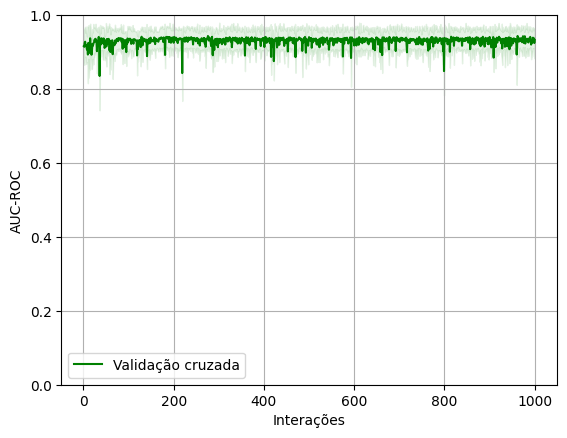

In [28]:
results_df_iforest2 = df_results_iforest[['roc_auc_mean', 'roc_auc_std']]

plot_learning_curve_cross_validation(results_df_iforest2, title="iforest", ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000))

In [29]:
df_results_iforest = pd.read_csv('./metrics_skab/results_iforest_tpe_dwt.csv')   

df_results_iforest['roc_auc_adjusted'] = df_results_iforest['roc_auc_mean'] - df_results_iforest['roc_auc_std']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = df_results_iforest['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
# best_params = df_results_iforest.loc[999]
best_params = df_results_iforest.loc[best_params_idx]  

print("\nMétricas:", best_params) 


Métricas: trial               275.000000
roc_auc_mean          0.943529
roc_auc_std           0.028094
value                91.543514
n_estimators         53.000000
contamination         0.002099
max_samples           0.943885
max_features          0.962890
roc_auc_adjusted      0.915435
Name: 275, dtype: float64


In [30]:
n_estimators_best = int(best_params_iforest.get('n_estimators'))
contamination_best = round(float(best_params_iforest.get('contamination')), 5)
max_samples_best = round(float(best_params_iforest.get('max_samples')), 2)
max_features_best = round(float(best_params_iforest.get('max_features')), 2)

print(f"Melhores parâmetros para Isolation Forest: n_estimators={n_estimators_best}, contamination={contamination_best}, max_samples={max_samples_best}, max_features={max_features_best}")

Melhores parâmetros para Isolation Forest: n_estimators=53, contamination=0.0021, max_samples=0.94, max_features=0.96


In [31]:
estimator  = IsolationForest(
    n_estimators=n_estimators_best,
    contamination=contamination_best,
    max_samples=max_samples_best,
    max_features=max_features_best,
    random_state=42
)

pipe_model_iforest = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)),
            ('estimator', estimator)
        ])

pipe_model_iforest.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['Volume Flow RateRMS_mean',
                                                 'Volume Flow RateRMS_std',
                                                 'Volume Flow RateRMS_min',
                                                 'Volume Flow RateRMS_max',
                                                 'Volume Flow '
                                                 'RateRMS_energy_L0',
                                                 'Volume Flow '
                                                 'RateRMS_std_L0'])),
                ('estimator',
                 IsolationForest(contamination=0.0021, max_features=0.96,
                                 max_samples=0.94, n_estimators=53,
                                 random_state=42))])

In [130]:
scores_dev = -pipe_model_iforest.decision_function(X_dev)

fpr, tpr, thresholds, best_threshold, roc_auc = find_optimal_threshold(y_dev, scores_dev, max_fpr=1)
print(f"Melhor Threshold (FPR ≤ 0.1): {best_threshold:.4f}, AUC: {roc_auc:.4f}")

y_pred = (scores_dev >= best_threshold).astype(int)
# y_pred = pipe_model_iforest.predict(X_dev)
# y_pred = np.where(y_pred == 1, 0, 1)  #
print("Melhore threshold: ", best_threshold)


Melhor Threshold (FPR ≤ 0.1): -0.1781, AUC: 0.9238
Melhore threshold:  -0.17806932764205263


Classification Report: 
               precision    recall  f1-score   support

         0.0    0.90547   0.94301   0.92386       193
         1.0    0.90678   0.84921   0.87705       126

    accuracy                        0.90596       319
   macro avg    0.90613   0.89611   0.90045       319
weighted avg    0.90599   0.90596   0.90537       319

Specificity: 0.9430051813471503
Gini:  0.847520355292376
ROC AUC::  0.923760177646188


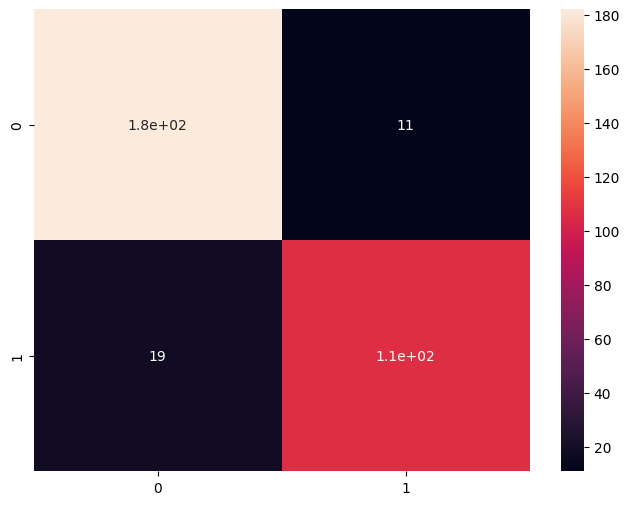

In [131]:
metrics(y_dev, y_pred, scores_dev)

In [132]:
X_valid = validation[feature_model].values
y_valid = validation['target'].values

In [133]:
scores_valid = -pipe_model_iforest.decision_function(X_valid)
y_pred = (scores_valid >= best_threshold).astype(int)
# y_pred = pipe_model_iforest.predict(X_valid)
# y_pred = np.where(y_pred == -1, 1, 0)  

In [134]:
# scores_valid = -pipe_model_iforest.decision_function(X_valid)
# final_auc = roc_auc_score(y_valid, scores_valid)
# # Calcular a curva ROC  
# fpr, tpr, thresholds = roc_curve(y_valid, scores_valid)  

# print(f"AUC final com melhores hiperparâmetros: {final_auc:.4f}")

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.89583   0.91489   0.90526        47
         1.0    0.87500   0.84848   0.86154        33

    accuracy                        0.88750        80
   macro avg    0.88542   0.88169   0.88340        80
weighted avg    0.88724   0.88750   0.88723        80

Specificity: 0.9148936170212766
Gini:  0.8181818181818183
ROC AUC::  0.9090909090909092


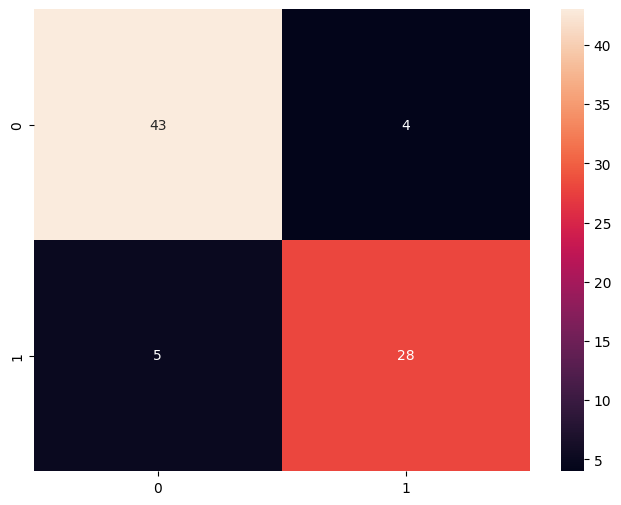

In [135]:
metrics(y_valid, y_pred, scores_valid)

In [136]:
validation['scores_forest']=-pipe_model_iforest.decision_function(X_valid)

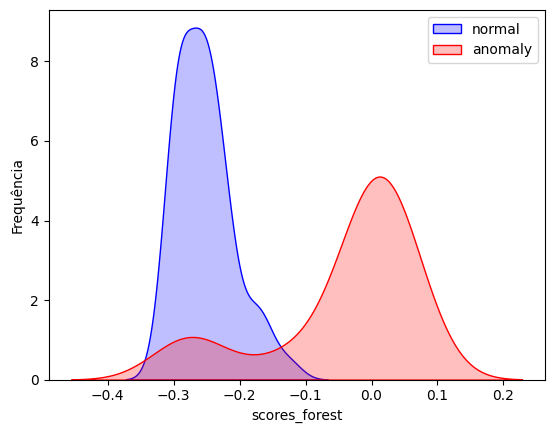

In [137]:
g = sns.kdeplot(validation["scores_forest"][(validation["target"] == 0) & (validation["scores_forest"].notnull())], color="Blue", fill = True)
g = sns.kdeplot(validation["scores_forest"][(validation["target"] == 1) & (validation["scores_forest"].notnull())], color="Red", fill = True)

g.set_xlabel("scores_forest")
g.set_ylabel("Frequência")
g = g.legend(['normal', 'anomaly'])

In [138]:
with open('./models_skab/pipeline_iForest_tpe_dwt.pkl', 'wb') as file: 
    pickle.dump(pipe_model_iforest, file)

## Local Outlier Factor

In [42]:
from sklearn.neighbors import LocalOutlierFactor

In [43]:
def build_lof(params):
    model = LocalOutlierFactor(
        n_neighbors=int(params['n_neighbors']),
        contamination=params['contamination'],
        novelty=True,
        n_jobs=-1
    )
    return Pipeline([
        ('scaler', StandardScaler()),
        ('estimator', model)
    ])

def transform_lof_params(params):
    return {
        'n_neighbors': int(params[0]),
        'contamination': float(params[1])
    }

def objective_lof(trial, dataset, tscv, features):
    n_neighbors = trial.suggest_int('n_neighbors', 3, 25)
    contamination = trial.suggest_float('contamination', 0.0001, 0.005)
    params = [n_neighbors, contamination]

    model_params = transform_lof_params(params)
    model = build_lof(model_params)
    mean_score, std_score = evaluate_model(model, dataset, tscv, features)

    trial.set_user_attr("score_mean", mean_score)
    trial.set_user_attr("score_std", std_score)

    return 100*(mean_score - std_score) 

def optuna_optimization_lof(dataset, tscv, features, n_trials=50):
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')
    study.optimize(lambda trial: objective_lof(trial, dataset, tscv, features), n_trials=n_trials)

    return study.best_params, study

In [44]:
import time
tscv = TimeSeriesSplit(n_splits=3)
start_time = time.time()  # Inicia o cronômetro

best_params_lof, study_lof = optuna_optimization_lof(development, tscv, feature_model, n_trials=1000)
print(f"Melhores parâmetros para LOF: {best_params_lof}")

total_time = time.time() - start_time  # Calcula o tempo total
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")

[I 2025-10-10 22:36:45,455] A new study created in memory with name: no-name-c813d2cf-2e73-494f-82c4-c104810b2c81
[I 2025-10-10 22:36:46,360] Trial 0 finished with value: 64.43398096498527 and parameters: {'n_neighbors': 4, 'contamination': 0.0014063792015546674}. Best is trial 0 with value: 64.43398096498527.
[I 2025-10-10 22:36:46,541] Trial 1 finished with value: 91.13612916712295 and parameters: {'n_neighbors': 13, 'contamination': 0.0035802851650932315}. Best is trial 1 with value: 91.13612916712295.
[I 2025-10-10 22:36:46,698] Trial 2 finished with value: 91.13179048730152 and parameters: {'n_neighbors': 12, 'contamination': 0.002313731897214558}. Best is trial 1 with value: 91.13612916712295.
[I 2025-10-10 22:36:46,848] Trial 3 finished with value: 90.98039103741769 and parameters: {'n_neighbors': 16, 'contamination': 0.0010695279413360887}. Best is trial 1 with value: 91.13612916712295.
[I 2025-10-10 22:36:47,000] Trial 4 finished with value: 68.97883259847522 and parameters: {

Melhores parâmetros para LOF: {'n_neighbors': 25, 'contamination': 0.004883652973574719}
Tempo total de execução: 389.75 segundos
Tempo total de execução: 6.50 minutos


In [45]:
data_metrics_lof = []

for trial in study_lof.trials:
    data_metrics_lof.append({
        'trial': trial.number,
        'roc_auc_mean': trial.user_attrs.get('score_mean'),
        'roc_auc_std': trial.user_attrs.get('score_std'),
        'value': trial.value,
        **trial.params
    })

df_results_lof = pd.DataFrame(data_metrics_lof)
df_results_lof.to_csv('./metrics_skab/results_lof_tpe_dwt.csv', index=False)
df_results_lof.head()

,trial,roc_auc_mean,roc_auc_std,value,n_neighbors,contamination
0,0,0.792186,0.147846,64.433981,4,0.001406
1,1,0.925775,0.014414,91.136129,13,0.003580
2,2,0.924660,0.013342,91.131790,12,0.002314
3,3,0.924219,0.014415,90.980391,16,0.001070
4,4,0.807936,0.118148,68.978833,5,0.001046


<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PhD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

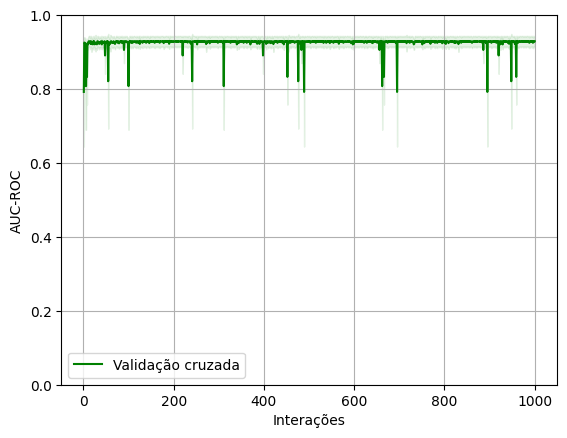

In [46]:
results_df_lof2 = df_results_lof[['roc_auc_mean', 'roc_auc_std']]

plot_learning_curve_cross_validation(results_df_lof2, title="lof", ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000))

In [47]:
df_results_lof = pd.read_csv('./metrics_skab/results_lof_tpe_dwt.csv')   

df_results_lof['roc_auc_adjusted'] = df_results_lof['roc_auc_mean'] - df_results_lof['roc_auc_std']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = df_results_lof['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
# best_params = df_results_lof.loc[999]
best_params = df_results_lof.loc[best_params_idx]  

print("\nMétricas:", best_params) 


Métricas: trial               11.000000
roc_auc_mean         0.929338
roc_auc_std          0.014539
value               91.479886
n_neighbors         25.000000
contamination        0.004884
roc_auc_adjusted     0.914799
Name: 11, dtype: float64


In [48]:
# best_params_lof = {
#  'contamination': 0.001554,
#  'n_neighbors': 25}

In [49]:
n_neighbors_best = int(round(best_params_lof.get('n_neighbors'), 0))
contamination_best = round(float(best_params_lof.get('contamination')), 5)

print(f"Melhores hiperparâmetros encontrados: n_neighbors={n_neighbors_best}, contamination={contamination_best}")

Melhores hiperparâmetros encontrados: n_neighbors=25, contamination=0.00488


In [50]:
estimator_lof  = LocalOutlierFactor(
    n_neighbors=n_neighbors_best,
    contamination=contamination_best,
    novelty=True,
    n_jobs=-1
)

estimator_lof 

LocalOutlierFactor(contamination=0.00488, n_jobs=-1, n_neighbors=25,
                   novelty=True)

In [51]:
pipe_model_lof = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)),
            ('estimator', estimator_lof)
        ])

In [52]:
pipe_model_lof.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['Volume Flow RateRMS_mean',
                                                 'Volume Flow RateRMS_std',
                                                 'Volume Flow RateRMS_min',
                                                 'Volume Flow RateRMS_max',
                                                 'Volume Flow '
                                                 'RateRMS_energy_L0',
                                                 'Volume Flow '
                                                 'RateRMS_std_L0'])),
                ('estimator',
                 LocalOutlierFactor(contamination=0.00488, n_jobs=-1,
                                    n_neighbors=25, novelty=True))])

In [124]:
scores_dev = -pipe_model_lof.decision_function(X_dev)

fpr, tpr, thresholds, best_threshold, roc_auc = find_optimal_threshold(y_dev, scores_dev, max_fpr=1)
print(f"Melhor Threshold (FPR ≤ 1): {best_threshold:.4f}, AUC: {roc_auc:.4f}")

y_pred = (scores_dev >= best_threshold).astype(int)
print("Melhore threshold: ", best_threshold)

# y_pred = pipe_model_lof.predict(X_dev)
# y_pred = np.where(y_pred == -1, 1, 0)  

Melhor Threshold (FPR ≤ 1): -2.3718, AUC: 0.9164
Melhore threshold:  -2.3718394228144764


Classification Report: 
               precision    recall  f1-score   support

         0.0    0.89806   0.95855   0.92732       193
         1.0    0.92920   0.83333   0.87866       126

    accuracy                        0.90909       319
   macro avg    0.91363   0.89594   0.90299       319
weighted avg    0.91036   0.90909   0.90810       319

Specificity: 0.9585492227979274
Gini:  0.8327165062916357
ROC AUC::  0.9163582531458179


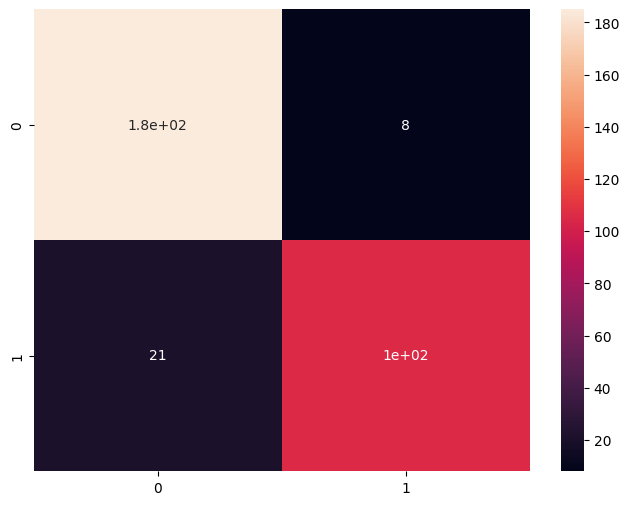

In [125]:
metrics(y_dev, y_pred, scores_dev)

In [126]:
X_valid = validation[feature_model].values
y_valid = validation['target'].values

In [127]:
scores_valid = -pipe_model_lof.decision_function(X_valid)
y_pred = (scores_valid >= best_threshold).astype(int)

# y_pred = pipe_model_lof.predict(X_valid)
# y_pred = np.where(y_pred == -1, 1, 0)  

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.89130   0.87234   0.88172        47
         1.0    0.82353   0.84848   0.83582        33

    accuracy                        0.86250        80
   macro avg    0.85742   0.86041   0.85877        80
weighted avg    0.86335   0.86250   0.86279        80

Specificity: 0.8723404255319149
Gini:  0.7704706640876853
ROC AUC::  0.8852353320438426


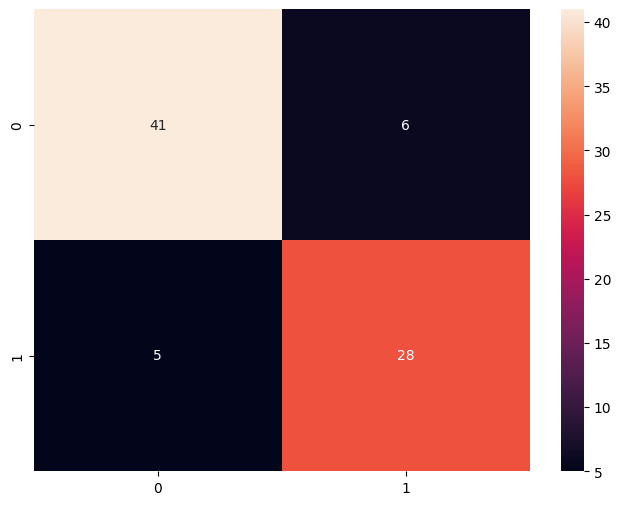

In [128]:
metrics(y_valid, y_pred, scores_valid)

In [129]:
with open('./models_skab/pipeline_LOF_tpe_dwt.pkl', 'wb') as file: 
    pickle.dump(pipe_model_lof, file)

## Algorithms Pyod
https://pyod.readthedocs.io/en/latest/

In [59]:
def evaluate_model_pyod(model, dataset, tscv, features):
    fit_scores = []
    for train_index, test_index in tscv.split(dataset):
        train_data = dataset.iloc[train_index]
        X_train = train_data[train_data['target'] == 0][features]
        X_test = dataset.iloc[test_index][features]
        y_test = dataset.iloc[test_index]['target']

        model.fit(X_train)
        y_scores = model.decision_function(X_test)
        # y_pred = model.predict(X_test)
        # score = f1_score(y_test, y_pred, average='binary', zero_division=0)
        score = roc_auc_score(y_test, y_scores)
        fit_scores.append(score)

    mean_score = np.mean(fit_scores)
    std_score = np.std(fit_scores)

    return mean_score, std_score

#### PCA

In [60]:
from pyod.models.pca import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import optuna

# Função para construir o modelo PCA com pipeline
def build_pca(params):
    model = PCA(
        contamination=params['contamination'], 
        n_components=params['n_components']
    )
    return Pipeline([
        ('scaler', StandardScaler()),
        ('estimator', model)
    ])

# Transformação de vetor para dicionário de parâmetros
def transform_pca_params(params):
    return {
        'contamination': float(params[0]), 
        'n_components': float(params[1])
    }

# Função objetivo do Optuna
def objective_pca(trial, dataset, tscv, features):
    contamination = trial.suggest_float('contamination', 0.0001, 0.005)
    n_components = trial.suggest_float('n_components', 0.5, 1.0)

    # Parâmetros como vetor para função de transformação
    params = [contamination, n_components]
    model_params = transform_pca_params(params)

    model = build_pca(model_params)
    mean_score, std_score = evaluate_model_pyod(model, dataset, tscv, features)

    trial.set_user_attr("score_mean", mean_score)
    trial.set_user_attr("score_std", std_score)

    return 100*(mean_score - std_score) 

# Execução da otimização com TPE
def optuna_optimization_pca(dataset, tscv, features, n_trials=50):
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')
    study.optimize(lambda trial: objective_pca(trial, dataset, tscv, features), n_trials=n_trials)
    return study.best_params, study


In [61]:
import time

start_time = time.time()  # Inicia o cronômetro

best_params_pca, study_pca = optuna_optimization_pca(development, tscv, feature_model, n_trials=1000)
print(f"Melhores parâmetros para pca: {best_params_pca}")

total_time = time.time() - start_time  # Calcula o tempo total
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")

[I 2025-10-10 22:43:18,510] A new study created in memory with name: no-name-cb443b0e-2fb1-465a-8dd7-156e3ec9f6f2
[I 2025-10-10 22:43:18,566] Trial 0 finished with value: 90.10939664387625 and parameters: {'contamination': 0.004756378959604708, 'n_components': 0.6989091309301949}. Best is trial 0 with value: 90.10939664387625.
[I 2025-10-10 22:43:18,637] Trial 1 finished with value: 90.10939664387625 and parameters: {'contamination': 0.0017118119576444355, 'n_components': 0.6322598947234006}. Best is trial 0 with value: 90.10939664387625.
[I 2025-10-10 22:43:18,698] Trial 2 finished with value: 91.81765391938215 and parameters: {'contamination': 0.00042510950432136636, 'n_components': 0.941266543262132}. Best is trial 2 with value: 91.81765391938215.
[I 2025-10-10 22:43:18,768] Trial 3 finished with value: 91.81765391938215 and parameters: {'contamination': 0.0014825058969939189, 'n_components': 0.8888928709236521}. Best is trial 2 with value: 91.81765391938215.
[I 2025-10-10 22:43:18,

Melhores parâmetros para pca: {'contamination': 0.00042510950432136636, 'n_components': 0.941266543262132}
Tempo total de execução: 147.23 segundos
Tempo total de execução: 2.45 minutos


In [62]:
data_metrics_pca = []

for trial in study_pca.trials:
    data_metrics_pca.append({
        'trial': trial.number,
        'roc_auc_mean': trial.user_attrs.get('score_mean'),
        'roc_auc_std': trial.user_attrs.get('score_std'),
        'value': trial.value,
        **trial.params
    })

df_results_pca = pd.DataFrame(data_metrics_pca)
df_results_pca.to_csv('./metrics_skab/results_pca_tpe_dwt.csv', index=False)
df_results_pca.head()

,trial,roc_auc_mean,roc_auc_std,value,contamination,n_components
0,0,0.932231,0.031137,90.109397,0.004756,0.698909
1,1,0.932231,0.031137,90.109397,0.001712,0.632260
2,2,0.935767,0.017591,91.817654,0.000425,0.941267
3,3,0.935767,0.017591,91.817654,0.001483,0.888893
4,4,0.935767,0.017591,91.817654,0.003935,0.902410


<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PhD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

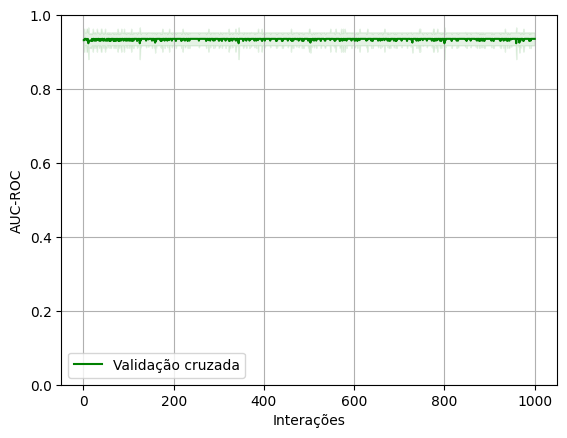

In [63]:
results_df_pca2 = df_results_pca[['roc_auc_mean', 'roc_auc_std']]

plot_learning_curve_cross_validation(results_df_pca2, title="pca", ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000))

In [64]:
df_results_pca = pd.read_csv('./metrics_skab/results_pca_tpe_dwt.csv')   

df_results_pca['roc_auc_adjusted'] = df_results_pca['roc_auc_mean'] - df_results_pca['roc_auc_std']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = df_results_pca['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
# best_params = df_results_pca.loc[999]
best_params = df_results_pca.loc[best_params_idx]  

print("\nMétricas:", best_params) 


Métricas: trial                2.000000
roc_auc_mean         0.935767
roc_auc_std          0.017591
value               91.817654
contamination        0.000425
n_components         0.941267
roc_auc_adjusted     0.918177
Name: 2, dtype: float64


In [65]:
n_components_best = float(round(best_params.get('n_components'), 2))
contamination_best = round(float(best_params.get('contamination')), 5)

print(f"Melhores hiperparâmetros encontrados: n_components={n_components_best}, contamination={contamination_best}")

Melhores hiperparâmetros encontrados: n_components=0.94, contamination=0.00043


In [66]:
if n_components_best==1.0:
    n_components_best=0.99
else:
    pass

In [67]:
estimator = PCA(random_state=42, 
                contamination = contamination_best,
                # n_components = n_components_best
                
                )
estimator

PCA(contamination=0.00043, copy=True, iterated_power='auto',
  n_components=None, n_selected_components=None, random_state=42,
  standardization=True, svd_solver='auto', tol=0.0, weighted=True,
  whiten=False)

In [68]:
# estimator = PCA(** best_params_pca, random_state=42)

pipe_model_pca = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)), 
            ('estimator', estimator)
        ])

pipe_model_pca.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['Volume Flow RateRMS_mean',
                                                 'Volume Flow RateRMS_std',
                                                 'Volume Flow RateRMS_min',
                                                 'Volume Flow RateRMS_max',
                                                 'Volume Flow '
                                                 'RateRMS_energy_L0',
                                                 'Volume Flow '
                                                 'RateRMS_std_L0'])),
                ('estimator',
                 PCA(contamination=0.00043, copy=True, iterated_power='auto',
  n_components=None, n_selected_components=None, random_state=42,
  standardization=True, svd_solver='auto', tol=0.0, weighted=True,
  whiten=False))])

In [118]:
# y_pred = pipe_model_pca.predict(development[feature_model])

scores_dev = pipe_model_pca.decision_function(X_dev)

fpr, tpr, thresholds, best_threshold, roc_auc = find_optimal_threshold(y_dev, scores_dev, max_fpr=1)
print(f"Melhor Threshold (FPR ≤ 1): {best_threshold:.4f}, AUC: {roc_auc:.4f}")

y_pred = (scores_dev >= best_threshold).astype(int)
print("Melhore threshold: ", best_threshold)

Melhor Threshold (FPR ≤ 1): 1189.0323, AUC: 0.9191
Melhore threshold:  1189.0323216555064


Classification Report: 
               precision    recall  f1-score   support

         0.0    0.89372   0.95855   0.92500       193
         1.0    0.92857   0.82540   0.87395       126

    accuracy                        0.90596       319
   macro avg    0.91115   0.89197   0.89947       319
weighted avg    0.90749   0.90596   0.90484       319

Specificity: 0.9585492227979274
Gini:  0.838144584258574
ROC AUC::  0.919072292129287


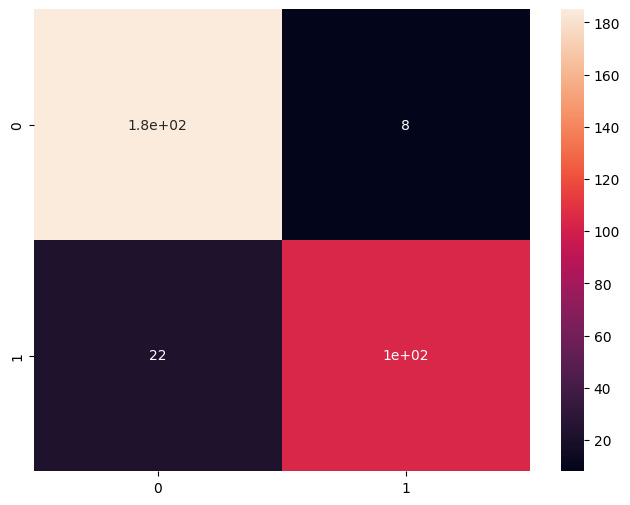

In [119]:
metrics(y_dev, y_pred, scores_dev)

In [120]:
X_valid = validation[feature_model].values
y_valid = validation['target'].values

In [121]:
scores_valid = pipe_model_pca.decision_function(X_valid)
y_pred = (scores_valid >= best_threshold).astype(int)
# y_pred = pipe_model_pca.predict(X_valid)
# y_test = validation.target.values

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.89362   0.89362   0.89362        47
         1.0    0.84848   0.84848   0.84848        33

    accuracy                        0.87500        80
   macro avg    0.87105   0.87105   0.87105        80
weighted avg    0.87500   0.87500   0.87500        80

Specificity: 0.8936170212765957
Gini:  0.8143133462282399
ROC AUC::  0.90715667311412


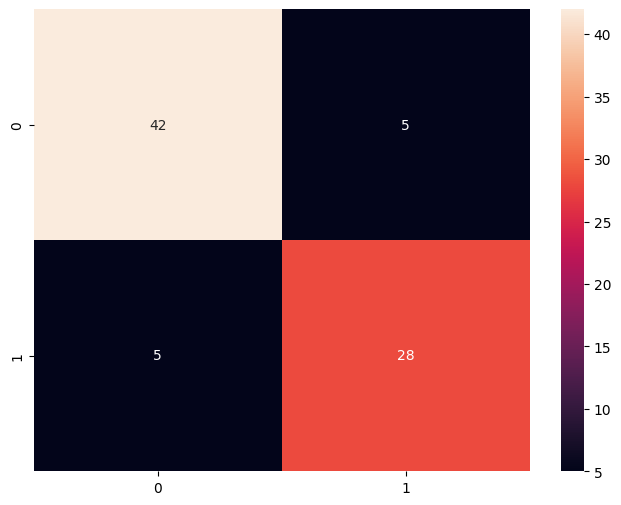

In [122]:
metrics(y_valid, y_pred, scores_valid)

In [123]:
with open('./models_skab/pipeline_PCA_tpe_dwt.pkl', 'wb') as file: 
    pickle.dump(pipe_model_pca, file)

#### LODA

In [75]:
from pyod.models.loda import LODA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import optuna

# Função para construir o modelo LODA
def build_loda(params):
    model = LODA(
        contamination=params['contamination'],
        n_bins=params['n_bins'],
        n_random_cuts=params['n_random_cuts']
    )
    return Pipeline([
        ('scaler', StandardScaler()),
        ('estimator', model)
    ])

# Função para transformar vetor de parâmetros em dicionário
def transform_loda_params(params):
    return {
        'contamination': float(params[0]),
        'n_bins': int(params[1]),
        'n_random_cuts': int(params[2])
    }

# Função objetivo para o Optuna
def objective_loda(trial, dataset, tscv, features):
    contamination = trial.suggest_float('contamination', 0.0001, 0.005)
    n_bins = trial.suggest_int('n_bins', 50, 5000)
    n_random_cuts = trial.suggest_int('n_random_cuts', 10, 1000)

    params = [contamination, n_bins, n_random_cuts]
    model_params = transform_loda_params(params)
    model = build_loda(model_params)

    mean_score, std_score = evaluate_model_pyod(model, dataset, tscv, features)

    trial.set_user_attr("score_mean", mean_score)
    trial.set_user_attr("score_std", std_score)

    return 100*(mean_score - std_score) 

# Execução da otimização com TPESampler
def optuna_optimization_loda(dataset, tscv, features, n_trials=50):
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')
    study.optimize(lambda trial: objective_loda(trial, dataset, tscv, features), n_trials=n_trials)
    return study.best_params, study


In [76]:
import time

start_time = time.time()  # Inicia o cronômetro

best_params_loda, study_loda = optuna_optimization_loda(development, tscv, feature_model, n_trials=1000)
print(f"Melhores parâmetros para loda: {best_params_loda}")

total_time = time.time() - start_time  # Calcula o tempo total
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")

[I 2025-10-10 22:45:49,151] A new study created in memory with name: no-name-1d0015b6-9c4f-410a-a75d-cab20cc50896
[I 2025-10-10 22:45:50,950] Trial 0 finished with value: 10.067328201980716 and parameters: {'contamination': 0.0025639856809947857, 'n_bins': 3036, 'n_random_cuts': 1000}. Best is trial 0 with value: 10.067328201980716.
[I 2025-10-10 22:45:51,128] Trial 1 finished with value: 10.009996040984056 and parameters: {'contamination': 0.00490924499719893, 'n_bins': 4359, 'n_random_cuts': 91}. Best is trial 0 with value: 10.067328201980716.
[I 2025-10-10 22:45:52,998] Trial 2 finished with value: 8.278882214571368 and parameters: {'contamination': 0.002204328631205318, 'n_bins': 3462, 'n_random_cuts': 379}. Best is trial 0 with value: 10.067328201980716.
[I 2025-10-10 22:45:57,243] Trial 3 finished with value: 9.781335171983871 and parameters: {'contamination': 0.004374128047860053, 'n_bins': 4298, 'n_random_cuts': 745}. Best is trial 0 with value: 10.067328201980716.
[I 2025-10-1

Melhores parâmetros para loda: {'contamination': 0.002879870071028419, 'n_bins': 51, 'n_random_cuts': 425}
Tempo total de execução: 548.18 segundos
Tempo total de execução: 9.14 minutos


In [77]:
data_metrics_loda = []

for trial in study_loda.trials:
    data_metrics_loda.append({
        'trial': trial.number,
        'roc_auc_mean': trial.user_attrs.get('score_mean'),
        'roc_auc_std': trial.user_attrs.get('score_std'),
        'value': trial.value,
        **trial.params
    })

df_results_loda = pd.DataFrame(data_metrics_loda)
df_results_loda.to_csv('./metrics_skab/results_loda_tpe_dwt.csv', index=False)
df_results_loda.head()

,trial,roc_auc_mean,roc_auc_std,value,contamination,n_bins,n_random_cuts
0,0,0.191172,0.090499,10.067328,0.002564,3036,1000
1,1,0.169535,0.069435,10.009996,0.004909,4359,91
2,2,0.169734,0.086945,8.278882,0.002204,3462,379
3,3,0.196944,0.099131,9.781335,0.004374,4298,745
4,4,0.196687,0.096048,10.063857,0.004389,2630,540


<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PhD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

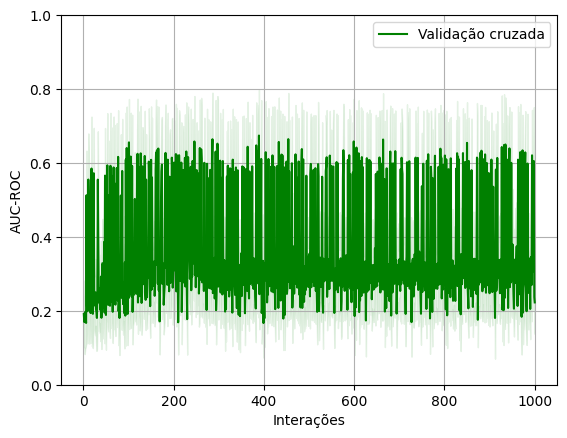

In [78]:
results_df_loda2 = df_results_loda[['roc_auc_mean', 'roc_auc_std']]

plot_learning_curve_cross_validation(results_df_loda2, title="loda", ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000))

In [79]:
df_results_loda = pd.read_csv('./metrics_skab/results_loda_tpe_dwt.csv')   

df_results_loda['roc_auc_adjusted'] = df_results_loda['roc_auc_mean'] - df_results_loda['roc_auc_std']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = df_results_loda['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
# best_params = df_results_loda.loc[999]
best_params = df_results_loda.loc[best_params_idx]  

print("\nMétricas:", best_params) 


Métricas: trial               388.000000
roc_auc_mean          0.674188
roc_auc_std           0.124033
value                55.015476
contamination         0.002880
n_bins               51.000000
n_random_cuts       425.000000
roc_auc_adjusted      0.550155
Name: 388, dtype: float64


In [80]:
best_params_loda

{'contamination': 0.002879870071028419, 'n_bins': 51, 'n_random_cuts': 425}

In [81]:
n_random_cuts_best = int(best_params_loda.get('n_random_cuts'))
contamination_best = round(float(best_params_loda.get('contamination')), 5)
n_bins_best = int(best_params_loda.get('n_bins'))


print(f"Melhores hiperparâmetros encontrados: n_random_cuts={n_random_cuts_best}, contamination={contamination_best}, "
      f"n_bins={n_bins_best}")


Melhores hiperparâmetros encontrados: n_random_cuts=425, contamination=0.00288, n_bins=51


In [82]:
estimator = LODA(contamination=contamination_best, n_bins=n_bins_best, n_random_cuts=n_random_cuts_best)

pipe_model_loda = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)), 
            ('estimator', estimator)
        ])

pipe_model_loda.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['Volume Flow RateRMS_mean',
                                                 'Volume Flow RateRMS_std',
                                                 'Volume Flow RateRMS_min',
                                                 'Volume Flow RateRMS_max',
                                                 'Volume Flow '
                                                 'RateRMS_energy_L0',
                                                 'Volume Flow '
                                                 'RateRMS_std_L0'])),
                ('estimator',
                 LODA(contamination=0.00288, n_bins=51, n_random_cuts=425))])

In [111]:
scores_dev = pipe_model_loda.decision_function(X_dev)

fpr, tpr, thresholds, best_threshold, roc_auc = find_optimal_threshold(y_dev, scores_dev, max_fpr=1)
print(f"Melhor Threshold (FPR ≤ 1): {best_threshold:.4f}, AUC: {roc_auc:.4f}")

y_pred = (scores_dev >= best_threshold).astype(int)
print("Melhore threshold: ", best_threshold)

Melhor Threshold (FPR ≤ 1): 0.0122, AUC: 0.8447
Melhore threshold:  0.012203030455646134


In [112]:
# y_pred = pipe_model_loda.predict(X_dev)

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.90798   0.76684   0.83146       193
         1.0    0.71154   0.88095   0.78723       126

    accuracy                        0.81191       319
   macro avg    0.80976   0.82390   0.80935       319
weighted avg    0.83039   0.81191   0.81399       319

Specificity: 0.7668393782383419
Gini:  0.6893659018011351
ROC AUC::  0.8446829509005676


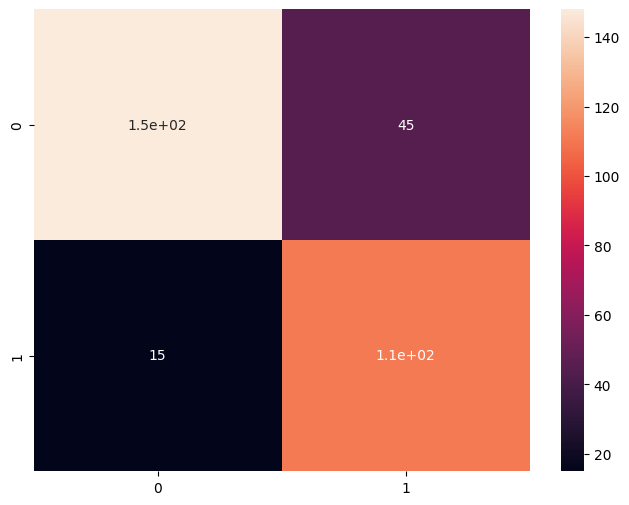

In [113]:
metrics(y_dev, y_pred, scores_dev)

In [114]:
X_valid = validation[feature_model].values
y_valid = validation['target'].values

In [115]:
scores_valid = pipe_model_loda.decision_function(X_valid)
y_pred = (scores_valid >= best_threshold).astype(int)

# y_pred = pipe_model_loda.predict(X_valid)
# y_test = validation.target.values

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.88889   0.85106   0.86957        47
         1.0    0.80000   0.84848   0.82353        33

    accuracy                        0.85000        80
   macro avg    0.84444   0.84977   0.84655        80
weighted avg    0.85222   0.85000   0.85058        80

Specificity: 0.851063829787234
Gini:  0.6673114119922632
ROC AUC::  0.8336557059961316


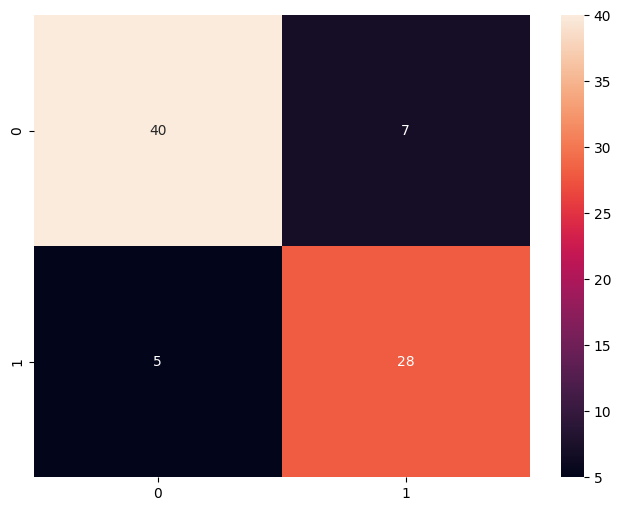

In [116]:
metrics(y_valid, y_pred, scores_valid)

In [117]:
with open('./models_skab/pipeline_LODA_tpe_dwt.pkl', 'wb') as file: 
    pickle.dump(pipe_model_loda, file)

### OCSVM

In [90]:
from pyod.models.ocsvm import OCSVM
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import optuna

def build_ocsvm(params):
    model = OCSVM(
        kernel=params['kernel'],
        nu=params['nu'],
        gamma=params['gamma']
    )
    return Pipeline([
        ('scaler', StandardScaler()),
        ('estimator', model)
    ])

def transform_ocsvm_params(params):
    return {
        'kernel': params[0],
        'nu': float(params[1]),
        'gamma': float(params[2])
    }

def objective_ocsvm(trial, dataset, tscv, features):
    kernel = trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly', 'sigmoid'])
    nu = trial.suggest_float('nu', 0.0001, 0.005)
    gamma = trial.suggest_float('gamma', 0.001, 0.1)

    params = [kernel, nu, gamma]
    model_params = transform_ocsvm_params(params)
    model = build_ocsvm(model_params)

    mean_score, std_score = evaluate_model_pyod(model, dataset, tscv, features)

    trial.set_user_attr("score_mean", mean_score)
    trial.set_user_attr("score_std", std_score)

    return 100 * (mean_score - std_score)

def optuna_optimization_ocsvm(dataset, tscv, features, n_trials=50):
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')
    study.optimize(lambda trial: objective_ocsvm(trial, dataset, tscv, features), n_trials=n_trials)
    return study.best_params, study


In [91]:
import time

start_time = time.time()  # Inicia o cronômetro

best_params_ocsvm, study_ocsvm = optuna_optimization_ocsvm(development, tscv, feature_model, n_trials=1000)
print(f"Melhores parâmetros para ocsvm: {best_params_ocsvm}")

total_time = time.time() - start_time  # Calcula o tempo total
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")

[I 2025-10-10 22:55:08,490] A new study created in memory with name: no-name-1129dc9f-11bd-44b5-94bf-cc6764bce3dd
[I 2025-10-10 22:55:08,565] Trial 0 finished with value: 39.55147958879843 and parameters: {'kernel': 'sigmoid', 'nu': 0.0011759837739711999, 'gamma': 0.07519885115153394}. Best is trial 0 with value: 39.55147958879843.
[I 2025-10-10 22:55:08,711] Trial 1 finished with value: 10.73200912354239 and parameters: {'kernel': 'poly', 'nu': 0.0010054419973743488, 'gamma': 0.058696977547618656}. Best is trial 0 with value: 39.55147958879843.
[I 2025-10-10 22:55:08,875] Trial 2 finished with value: 84.17508298386514 and parameters: {'kernel': 'rbf', 'nu': 0.002481178980594067, 'gamma': 0.09961082945269735}. Best is trial 2 with value: 84.17508298386514.
[I 2025-10-10 22:55:09,094] Trial 3 finished with value: 36.267955359658245 and parameters: {'kernel': 'linear', 'nu': 0.001702811565123484, 'gamma': 0.012507029265337928}. Best is trial 2 with value: 84.17508298386514.
[I 2025-10-10

Melhores parâmetros para ocsvm: {'kernel': 'poly', 'nu': 0.0006505773477513437, 'gamma': 0.012367552754480458}
Tempo total de execução: 141.41 segundos
Tempo total de execução: 2.36 minutos


In [92]:
data_metrics_ocsvm = []

for trial in study_ocsvm.trials:
    data_metrics_ocsvm.append({
        'trial': trial.number,
        'roc_auc_mean': trial.user_attrs.get('score_mean'),
        'roc_auc_std': trial.user_attrs.get('score_std'),
        'value': trial.value,
        **trial.params
    })

df_results_ocsvm = pd.DataFrame(data_metrics_ocsvm)
df_results_ocsvm.to_csv('./metrics_skab/results_ocsvm_tpe_dwt.csv', index=False)
df_results_ocsvm.head()

,trial,roc_auc_mean,roc_auc_std,value,kernel,nu,gamma
0,0,0.550627,0.155112,39.551480,sigmoid,0.001176,0.075199
1,1,0.206930,0.099610,10.732009,poly,0.001005,0.058697
2,2,0.889315,0.047565,84.175083,rbf,0.002481,0.099611
3,3,0.581036,0.218356,36.267955,linear,0.001703,0.012507
4,4,0.361843,0.039417,32.242619,linear,0.002012,0.070277


<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PhD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

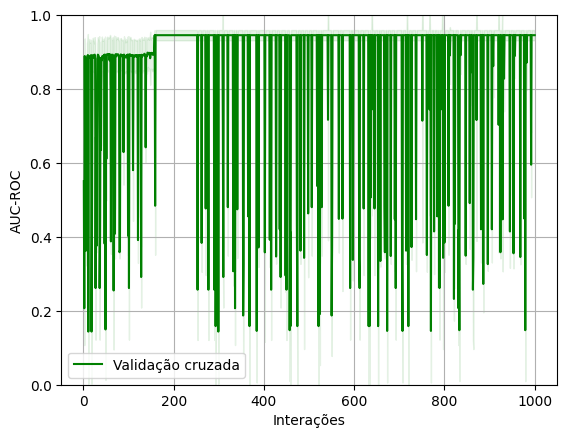

In [93]:
results_df_ocsvm2 = df_results_ocsvm[['roc_auc_mean', 'roc_auc_std']]

plot_learning_curve_cross_validation(results_df_ocsvm2, title="ocsvm", ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000))

In [94]:
df_results_ocsvm = pd.read_csv('./metrics_skab/results_ocsvm_tpe_dwt.csv')   

df_results_ocsvm['roc_auc_adjusted'] = df_results_ocsvm['roc_auc_mean'] - df_results_ocsvm['roc_auc_std']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = df_results_ocsvm['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
# best_params = df_results_ocsvm.loc[999]
best_params = df_results_ocsvm.loc[best_params_idx]  

print("\nMétricas:", best_params) 


Métricas: trial                     157
roc_auc_mean         0.945719
roc_auc_std          0.013989
value               93.173068
kernel                   poly
nu                   0.000651
gamma                0.012368
roc_auc_adjusted     0.931731
Name: 157, dtype: object


In [95]:
kernel_best = best_params_ocsvm.get('kernel')
nu_best = round(float(best_params_ocsvm.get('nu')), 5)
gamma_best = round(float(best_params_ocsvm.get('gamma')), 3)

print(f"Melhores hiperparâmetros encontrados: kernel={kernel_best}, nu={nu_best}, gamma={gamma_best}")


Melhores hiperparâmetros encontrados: kernel=poly, nu=0.00065, gamma=0.012


In [96]:
estimator = OCSVM(
    kernel=kernel_best,
    nu=nu_best,
    gamma=gamma_best
)

In [97]:
pipe_model_ocsvm = Pipeline([
    ('scaler', StandardScaler()),
    ('to_dataframe', ToDataFrameTransformer(columns=feature_model)), 
    ('estimator', estimator)
])

# Treinar no conjunto sem anomalias
pipe_model_ocsvm.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['Volume Flow RateRMS_mean',
                                                 'Volume Flow RateRMS_std',
                                                 'Volume Flow RateRMS_min',
                                                 'Volume Flow RateRMS_max',
                                                 'Volume Flow '
                                                 'RateRMS_energy_L0',
                                                 'Volume Flow '
                                                 'RateRMS_std_L0'])),
                ('estimator',
                 OCSVM(cache_size=200, coef0=0.0, contamination=0.1, degree=3, gamma=0.012,
   kernel='poly', max_iter=-1, nu=0.00065, shrinking=True, tol=0.001,
   verbose=False))])

In [106]:
scores_dev = pipe_model_ocsvm.decision_function(X_dev)

# Encontrar o melhor threshold
fpr, tpr, thresholds, best_threshold, roc_auc = find_optimal_threshold(y_dev, scores_dev, max_fpr=1.0)
print(f"Melhor Threshold (FPR ≤ 1): {best_threshold:.4f}, AUC: {roc_auc:.4f}")

# Prever usando o threshold escolhido
y_pred = (scores_dev >= best_threshold).astype(int)
# y_pred = pipe_model_ocsvm.predict(X_dev)
print("Melhor threshold: ", best_threshold)

Melhor Threshold (FPR ≤ 1): 0.0001, AUC: 0.9036
Melhor threshold:  9.44441563449563e-05


Classification Report: 
               precision    recall  f1-score   support

         0.0    0.85922   0.91710   0.88722       193
         1.0    0.85841   0.76984   0.81172       126

    accuracy                        0.85893       319
   macro avg    0.85882   0.84347   0.84947       319
weighted avg    0.85890   0.85893   0.85740       319

Specificity: 0.917098445595855
Gini:  0.8071387449625791
ROC AUC::  0.9035693724812895


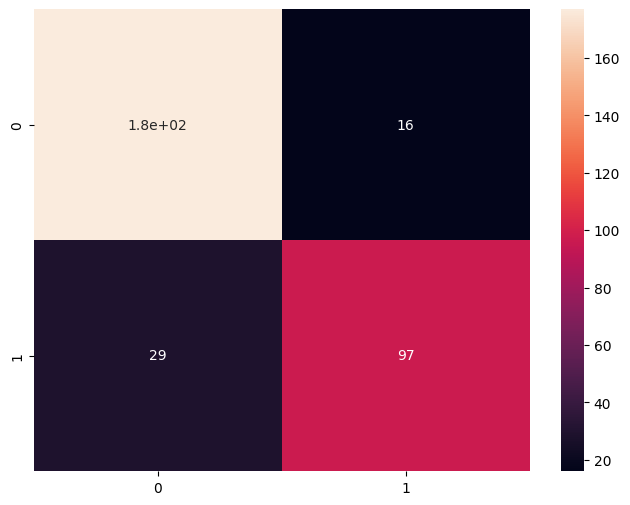

In [107]:
metrics(y_dev, y_pred, scores_dev)

In [108]:
X_valid = validation[feature_model].values
y_valid = validation['target'].values

In [109]:
scores_valid = pipe_model_ocsvm.decision_function(X_valid)
y_pred = (scores_valid >= best_threshold).astype(int)
# y_test = validation.target.values
# y_pred = pipe_model_ocsvm.predict(X_valid)

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.90909   0.85106   0.87912        47
         1.0    0.80556   0.87879   0.84058        33

    accuracy                        0.86250        80
   macro avg    0.85732   0.86493   0.85985        80
weighted avg    0.86638   0.86250   0.86322        80

Specificity: 0.851063829787234
Gini:  0.8916827852998064
ROC AUC::  0.9458413926499032


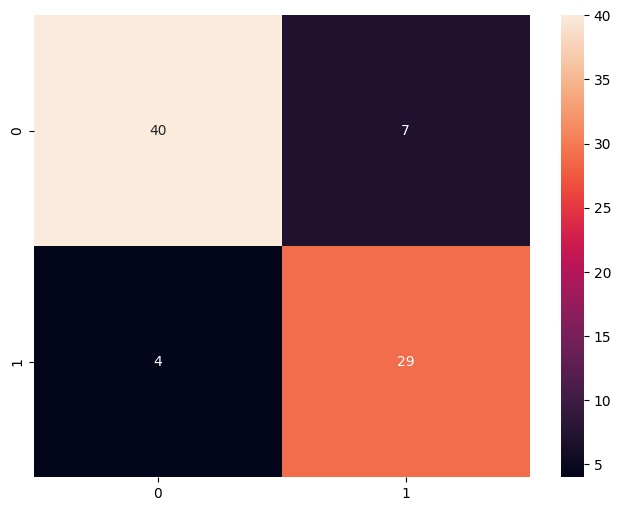

In [110]:
metrics(y_valid, y_pred, scores_valid)

In [103]:
validation['scores_ocsvm']= pipe_model_ocsvm.decision_function(X_valid)

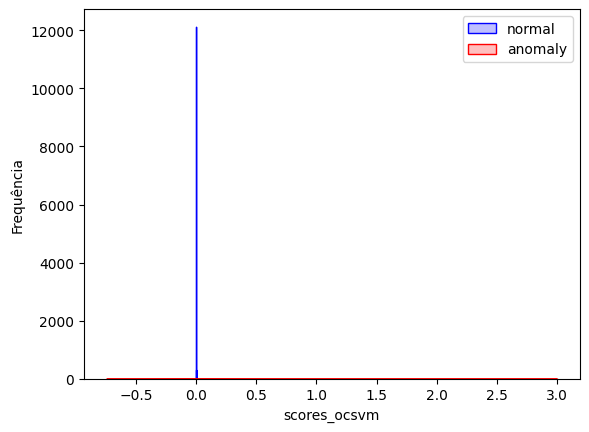

In [104]:
g = sns.kdeplot(validation["scores_ocsvm"][(validation["target"] == 0) & (validation["scores_ocsvm"].notnull())], color="Blue", fill = True)
g = sns.kdeplot(validation["scores_ocsvm"][(validation["target"] == 1) & (validation["scores_ocsvm"].notnull())], color="Red", fill = True)

g.set_xlabel("scores_ocsvm")
g.set_ylabel("Frequência")
g = g.legend(['normal', 'anomaly'])

In [105]:
with open('./models_skab/pipeline_OCSVM_tpe_dwt.pkl', 'wb') as file: 
    pickle.dump(pipe_model_ocsvm, file)